<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Automated_Object_Detection/02_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 2. Object tracking for lab videos
Created by: Karan Shah

In [ ]:
# Get res dir and helper files
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("Colab detected. (Re)Loading resources from github")
    os.system("rm -rf images")
    os.system("rm -rf experiments")
    os.system("rm -f colab_archive.tar.gz")
    os.system("wget https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Automated_Object_Detection/colab_archive.tar.gz?raw=true")
    os.system("mv colab_archive.tar.gz?raw=true colab_archive.tar.gz")
    os.system("tar -xzf colab_archive.tar.gz")

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, fixed
import ipywidgets as widgets
from scipy.signal import savgol_filter

# %matplotlib notebook

In [2]:
#helper code
def interactive_viz_colour(t,name, gs=False):
    #tstr = str(t).zfill(2)
    fname = f"02_tracking_data/{name}_{t}.jpg"
    image = plt.imread(fname)
    plt.figure(figsize=(8,6))
    plt.axis('off')
    if gs:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()
    
def interact_func(name, gs=False):
    interact(interactive_viz_colour, t=widgets.IntSlider(min=0, max=max_frame, step=1, value=0), name=fixed(name), gs=fixed(gs))

def plot_trajectory(traj_x, traj_y, traj_s, t_arr, name, ylabel):
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 3))

    fig.suptitle(name)
    ax1.set_title('x')
    ax1.plot(t_arr, traj_x)
    ax2.set_title('y')
    ax2.plot(t_arr, traj_y)
    ax3.set_title('net scalar')
    ax3.plot(t_arr, traj_s)
    fig.supxlabel('t')
    fig.supylabel(ylabel)
    plt.tight_layout()
    return fig


## Video Object Tracking

Now we will use the operations we learnt in the last notebook to track moving objects in a video. This can be helpful to get the trajectory of objects in lab experiments. Instead of the code we wrote, we will use the `opencv` library (refered to as `cv2`). 

Let's begin by loading the video using `cv2.VideoCapture`.

In [3]:
experiment_dir = 'experiments/inclined_plane/'
os.chdir(experiment_dir)
fname = 'video.mp4'
capture = cv2.VideoCapture(fname)

Now we go through the video frame by frame. Keep in mind that each frame is an 2D array of pixels.

In [4]:
capture.set(cv2.CAP_PROP_POS_AVI_RATIO, 0)

read_flag, img_1 = capture.read()
i = 0
while capture.isOpened():
    read_flag, img_2 = capture.read()
    if not read_flag:
        break
    
    if not os.path.exists('02_tracking_data'):
        os.makedirs('02_tracking_data')
    
    cv2.imwrite(f'02_tracking_data/orig_{i}.jpg', img_1)
    i+=1
    img_1 = img_2

max_frame = i-1
print(f"There are {i} frames in this video.")

There are 39 frames in this video.


In [5]:
interact_func('orig')

interactive(children=(IntSlider(value=0, description='t', max=38), Output()), _dom_classes=('widget-interact',…

You can move the slider to go through the video frame by frame.

### Get Object Coordinates and Bounding Boxes

Now that we have the video loaded, let's start extracting information from it. Here we implement a simple tracking algorithm that works by looking at differences in the pixel between two consecutive frames and generate a bounding box around the region of difference. A bounding box is a rectangle that defines the area of interest. A bounding box is defined by a list of 4 numbers $[x,y,h,w]$, with origin at top-left. The vertices of the box are $(x,y), (x,y+h), (x+w,y), (x+w,y+h)$. We will then use the bounding box to caluclate the approximate coordinates of the ball.

This approach works when we have a single moving object in our video, with a static background.

We will first run the whole algorithm across the video and save the intermediate frames. Then we will go through each step in brief detail.

In [6]:
# Initialize empty lists for bounding boxes

i = 0
x_list = []
y_list = []
h_list = []
w_list = []

capture.set(cv2.CAP_PROP_POS_AVI_RATIO, 0)
read_flag, img_1 = capture.read()
# img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

In [7]:
while capture.isOpened():
    # to read frame by frame
    read_flag, img_2 = capture.read()
    
    if not read_flag:
        break

    cv2.imwrite(f'02_tracking_data/orig_{i}.jpg', img_1)
    # find difference between two frames
    
    diff = cv2.absdiff(img_1, img_2)
    cv2.imwrite(f'02_tracking_data/diff_{i}.jpg', diff)
    # to convert the frame to grayscale
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(f'02_tracking_data/diff_gray_{i}.jpg', diff_gray)
    # apply some blur to smoothen the frame
    diff_blur = cv2.GaussianBlur(diff_gray, (5, 5), 0)
    cv2.imwrite(f'02_tracking_data/diff_blur_{i}.jpg', diff_blur)
    # to get the binary image
    _, thresh_bin = cv2.threshold(diff_blur, 20, 255, cv2.THRESH_BINARY)
    cv2.imwrite(f'02_tracking_data/thresh_bin_{i}.jpg', thresh_bin)
    # to find contours
    
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 30))
    thresh_bin_comb = cv2.morphologyEx(thresh_bin, cv2.MORPH_CLOSE, rect_kernel)
    cv2.imwrite(f'02_tracking_data/thresh_bin_comb_{i}.jpg', thresh_bin_comb)
    
    #contours, hierarchy = cv2.findContours(thresh_bin_comb, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(thresh_bin_comb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # to draw the bounding box when the motion is detected
        
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        x_list.append(x)
        y_list.append(y)
        h_list.append(h)
        w_list.append(w)
        hull = cv2.convexHull(contour)
        hulls = cv2.drawContours(img_1, [hull], -1, (0, 0, 255), 1) 
        cv2.imwrite(f'02_tracking_data/hulls_{i}.jpg', hulls)
        
        if cv2.contourArea(contour) > 300:
            cv2.rectangle(img_1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.drawContours(img_1, contours, -1, (0, 255, 0), 2)
    print(f"{i=} | Coords: {x=}, {y=}, {w=}, {h=} | Detections: {len(contours)}")
    cv2.imwrite(f'02_tracking_data/img_{i}.jpg', img_1)
    i+=1
    img_1 = img_2

i=0 | Coords: x=43, y=88, w=55, h=49 | Detections: 1
i=1 | Coords: x=47, y=88, w=56, h=51 | Detections: 1
i=2 | Coords: x=52, y=88, w=55, h=51 | Detections: 1
i=3 | Coords: x=57, y=88, w=56, h=52 | Detections: 1
i=4 | Coords: x=64, y=89, w=56, h=51 | Detections: 1
i=5 | Coords: x=71, y=89, w=56, h=53 | Detections: 1
i=6 | Coords: x=77, y=90, w=58, h=52 | Detections: 1
i=7 | Coords: x=85, y=90, w=59, h=54 | Detections: 1
i=8 | Coords: x=93, y=91, w=60, h=53 | Detections: 1
i=9 | Coords: x=103, y=92, w=59, h=52 | Detections: 1
i=10 | Coords: x=113, y=93, w=60, h=54 | Detections: 1
i=11 | Coords: x=123, y=94, w=62, h=53 | Detections: 1
i=12 | Coords: x=135, y=95, w=61, h=54 | Detections: 1
i=13 | Coords: x=146, y=95, w=63, h=55 | Detections: 1
i=14 | Coords: x=160, y=96, w=61, h=55 | Detections: 1
i=15 | Coords: x=173, y=97, w=62, h=55 | Detections: 1
i=16 | Coords: x=184, y=98, w=65, h=55 | Detections: 1
i=17 | Coords: x=199, y=99, w=65, h=56 | Detections: 1
i=18 | Coords: x=216, y=101, 

In [8]:
interact_func('orig', gs=False)


interactive(children=(IntSlider(value=0, description='t', max=38), Output()), _dom_classes=('widget-interact',…

Get the difference between frames:
```python
diff = cv2.absdiff(img_1, img_2)
```


In [9]:
interact_func('diff', gs=False)


interactive(children=(IntSlider(value=0, description='t', max=38), Output()), _dom_classes=('widget-interact',…

Convert the diff frame to grayscale:
```python
diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
```

In [10]:
interact_func('diff_gray', gs=True)


interactive(children=(IntSlider(value=0, description='t', max=38), Output()), _dom_classes=('widget-interact',…

Apply a gaussian blur to smoothen the edges:
```python
diff_blur = cv2.GaussianBlur(diff_gray, (5, 5), 0)
```

In [11]:
interact_func('diff_blur', gs=True)


interactive(children=(IntSlider(value=0, description='t', max=38), Output()), _dom_classes=('widget-interact',…

Apply a binary threshold to demarcate pixels that change between subsequent frames:
```python
_, thresh_bin = cv2.threshold(diff_blur, 20, 255, cv2.THRESH_BINARY)
```

In [12]:
interact_func('thresh_bin', gs=True)


interactive(children=(IntSlider(value=0, description='t', max=38), Output()), _dom_classes=('widget-interact',…

Find areas that are surrounded by selected pixels to create one continuous component
```python
thresh_bin_comb = cv2.morphologyEx(thresh_bin, cv2.MORPH_CLOSE, rect_kernel)
```

In [13]:
interact_func('thresh_bin_comb', gs=True)


interactive(children=(IntSlider(value=0, description='t', max=38), Output()), _dom_classes=('widget-interact',…

Finally, use the component detected to make a bounding box
```python
contours, hierarchy = cv2.findContours(thresh_bin_comb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
```

In [14]:
interact_func('img', gs=False)


interactive(children=(IntSlider(value=0, description='t', max=38), Output()), _dom_classes=('widget-interact',…

## Get kinematics

Now that we have coordinates of the object, we can use them to calculate position, velocity and acceleration.

In [15]:
golf_ball_diam_m = 0.0427
golf_ball_diam_pix = 55

pix_to_m = 1.0
frame_to_s = 1.0
convert = False
if convert:
    pix_to_m = golf_ball_diam_m/golf_ball_diam_pix  
    frame_to_s = 1.3/39

To remove initial and final bumps, we discard a few initial and final frames.

In [16]:
window_start = 2
window_end = max_frame-1

analysis_window = np.arange(window_start, window_end)
window_length = len(analysis_window)

print(f"Using {window_length} frames, discarding {max_frame-window_length} frames.")

x_arr = np.asarray(x_list)[analysis_window]
y_arr = np.asarray(y_list)[analysis_window]
h_arr = np.asarray(h_list)[analysis_window]
w_arr = np.asarray(w_list)[analysis_window]

t_arr = np.arange(window_length) * frame_to_s


Using 35 frames, discarding 3 frames.


Because the object tracker results can be noisy, we use a filter called savgol filter to smoothen the data.

In [17]:
filter_win_length = window_length

In [18]:
# center_x = (x_arr + h_arr/2)*pix_to_m
# center_y = (y_arr + w_arr/2)*pix_to_m
 
center_x = x_arr * pix_to_m
center_y = y_arr * pix_to_m

s_x = center_x - center_x[0]
s_y = center_y[-1] - center_y
s_net = np.sqrt(s_x**2 + s_y**2)

s_x = savgol_filter(s_x, filter_win_length, 3)
s_y = savgol_filter(s_y, filter_win_length, 3)

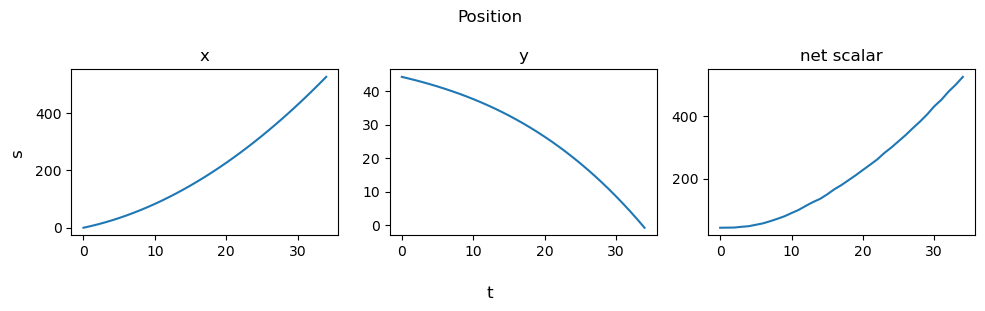

In [19]:
fig = plot_trajectory(s_x, s_y, s_net, t_arr, 'Position', 's')
plt.show()

Now we calculate the gradients of the position to get velocity.

In [20]:
v_x = np.gradient(s_x,frame_to_s)
v_y = np.gradient(s_y,frame_to_s)

v_x = savgol_filter(v_x, filter_win_length, 3)
v_y = savgol_filter(v_y, filter_win_length, 3)

v_net = np.sqrt(v_x**2 * v_y**2)
# v_net = np.gradient(s_net,4)
v_net = savgol_filter(v_net, filter_win_length, 3)

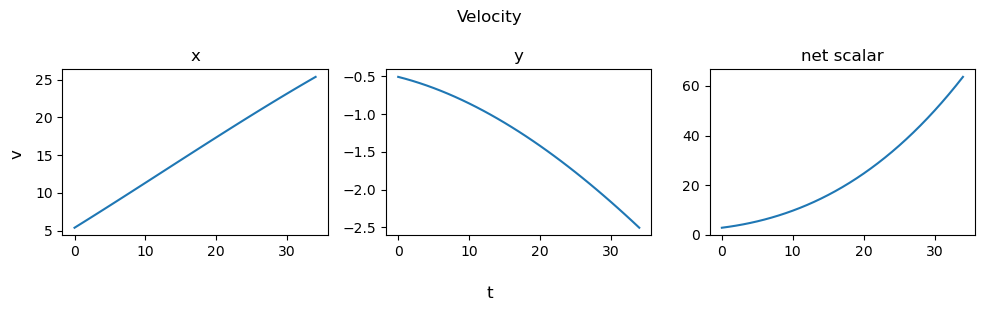

In [21]:
fig = plot_trajectory(v_x, v_y, v_net, t_arr, 'Velocity', 'v')
plt.show()

Finally, we calculate the gradients of the velocity to get acceleration.

In [22]:
a_x = np.gradient(v_x,frame_to_s)
a_y = np.gradient(v_y,frame_to_s)
# a_net = np.gradient(v_net,4)
a_net = np.sqrt(a_x**2 + a_y**2)

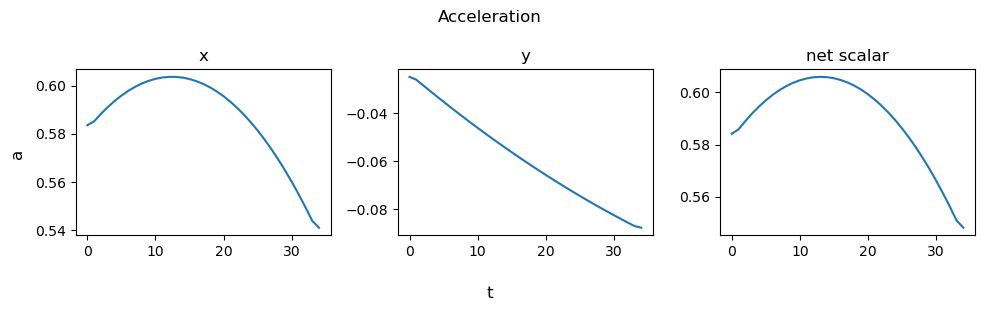

In [23]:
fig = plot_trajectory(a_x, a_y, a_net, t_arr, 'Acceleration', 'a')
plt.show()

## Discussion

In this toy case, we couldn't get accurate acceleration values. This can be due to multiple reasons:

1. The video framerate is low. Notice that in the latter part of the video, the ball is moving two fast between the frames, leading to artifacts like these:
![artifacts](./images/02_artifact_0.png)
![artifacts](./images/02_artifact_1.png)


This can distort coordinates of the ball calculated from the bounding boxes.

Remedy: Use a higher framerate video.

2. Noise in the data. The calculated coordinates are noisy, which leads to sharp peaks in the derivatives. One option is to experiment with different smoothening algorithms. Another option is to use other numerical differentiation schemes.

You can read further about different numerical schemes in this DSECOP module:
[Solving Differential Equations in Classical Mechanics with Neural Networks](https://github.com/GDS-Education-Community-of-Practice/DSECOP/tree/main/Solving_Differential_Equations_with_NNs)


## Conclusion

We implemented an object tracker, but the results are not so great and we need to tune parameters of the different image operations for each video. However, there are more sophisticated object trackers and even deep learning models that segment images and track objects of interests. We will talk about them in the next part.

To get a feel for neural networks, you can try other modules that introduce them:
1. [Intro to deep learning](https://github.com/GDS-Education-Community-of-Practice/DSECOP/tree/main/Intro_to_Deep_Learning)
2. [Gentle introduction to NNs using pixels](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/00_NN_Basics.ipynb)



## References
Inclined plane video: https://www.youtube.com/watch?v=LQMQLcV0Mwg